In [0]:
!unzip ibm-hr-analytics-attrition-dataset.zip

Archive:  ibm-hr-analytics-attrition-dataset.zip
  inflating: WA_Fn-UseC_-HR-Employee-Attrition.csv  


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pylab as pl
from sklearn.metrics import roc_curve, auc
from sklearn import metrics    
from sklearn import feature_selection
import itertools
from sklearn.model_selection import cross_val_score
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

In [129]:
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [130]:
df.isnull().sum() #To check whether there are any missing values

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

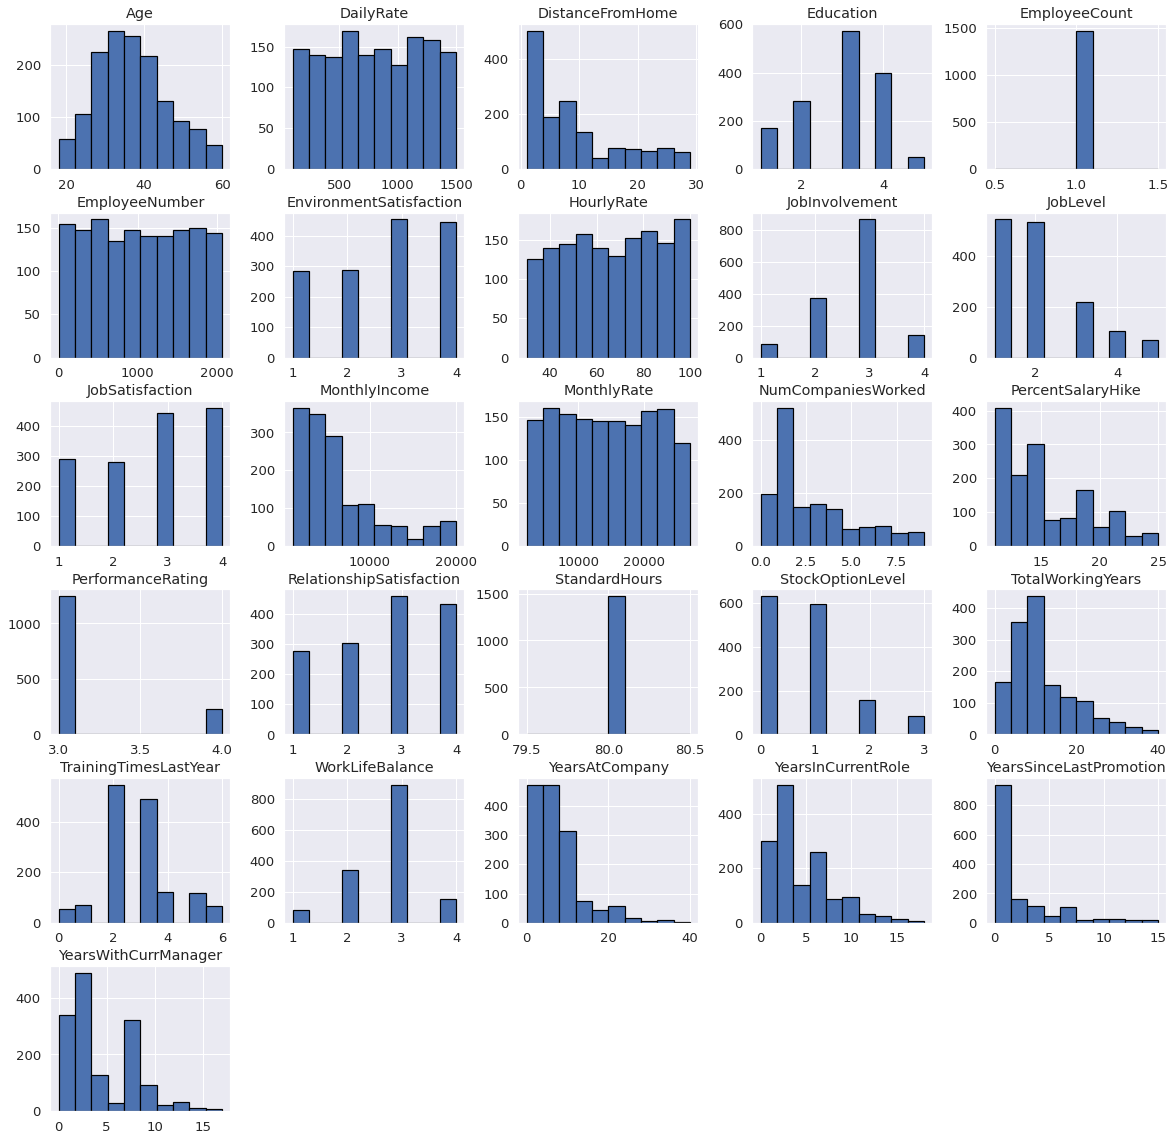

In [131]:
df.hist(edgecolor='black', linewidth=1.2, figsize=(20, 20));

As we see that standard deviation for EmployeeCount, StandardHours, Over18 is near zero so we can remove them. EmployeeNumber is an Indentification number which won't be helpful in prediction so we will also drop it.

In [0]:
df.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis="columns", inplace=True)

In [133]:
categorical_col = []
for column in df.columns:
    if df[column].dtype == object and len(df[column].unique()) <= 50:
        categorical_col.append(column)
        print(f"{column} : {df[column].unique()}")
        print("====================================")

Attrition : ['Yes' 'No']
BusinessTravel : ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
Department : ['Sales' 'Research & Development' 'Human Resources']
EducationField : ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
Gender : ['Female' 'Male']
JobRole : ['Sales Executive' 'Research Scientist' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative' 'Manager'
 'Sales Representative' 'Research Director' 'Human Resources']
MaritalStatus : ['Single' 'Married' 'Divorced']
OverTime : ['Yes' 'No']


In [0]:
df['Attrition'] = df.Attrition.astype("category").cat.codes

In [0]:
def plot_cat(attr,labels=None):
    if(attr=='JobRole'):
        sns.factorplot(data=df,kind='count',size=5,aspect=3,x=attr)
        return
    
    sns.factorplot(data=df,kind='count',size=5,aspect=1.5,x=attr)

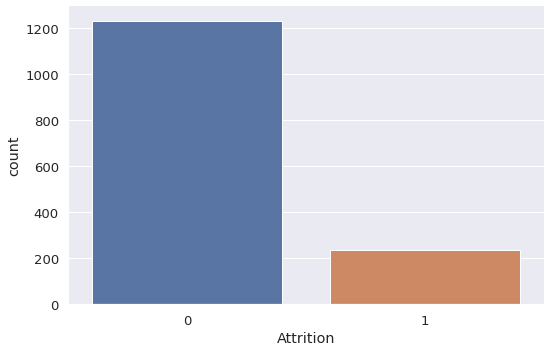

In [136]:
plot_cat('Attrition')

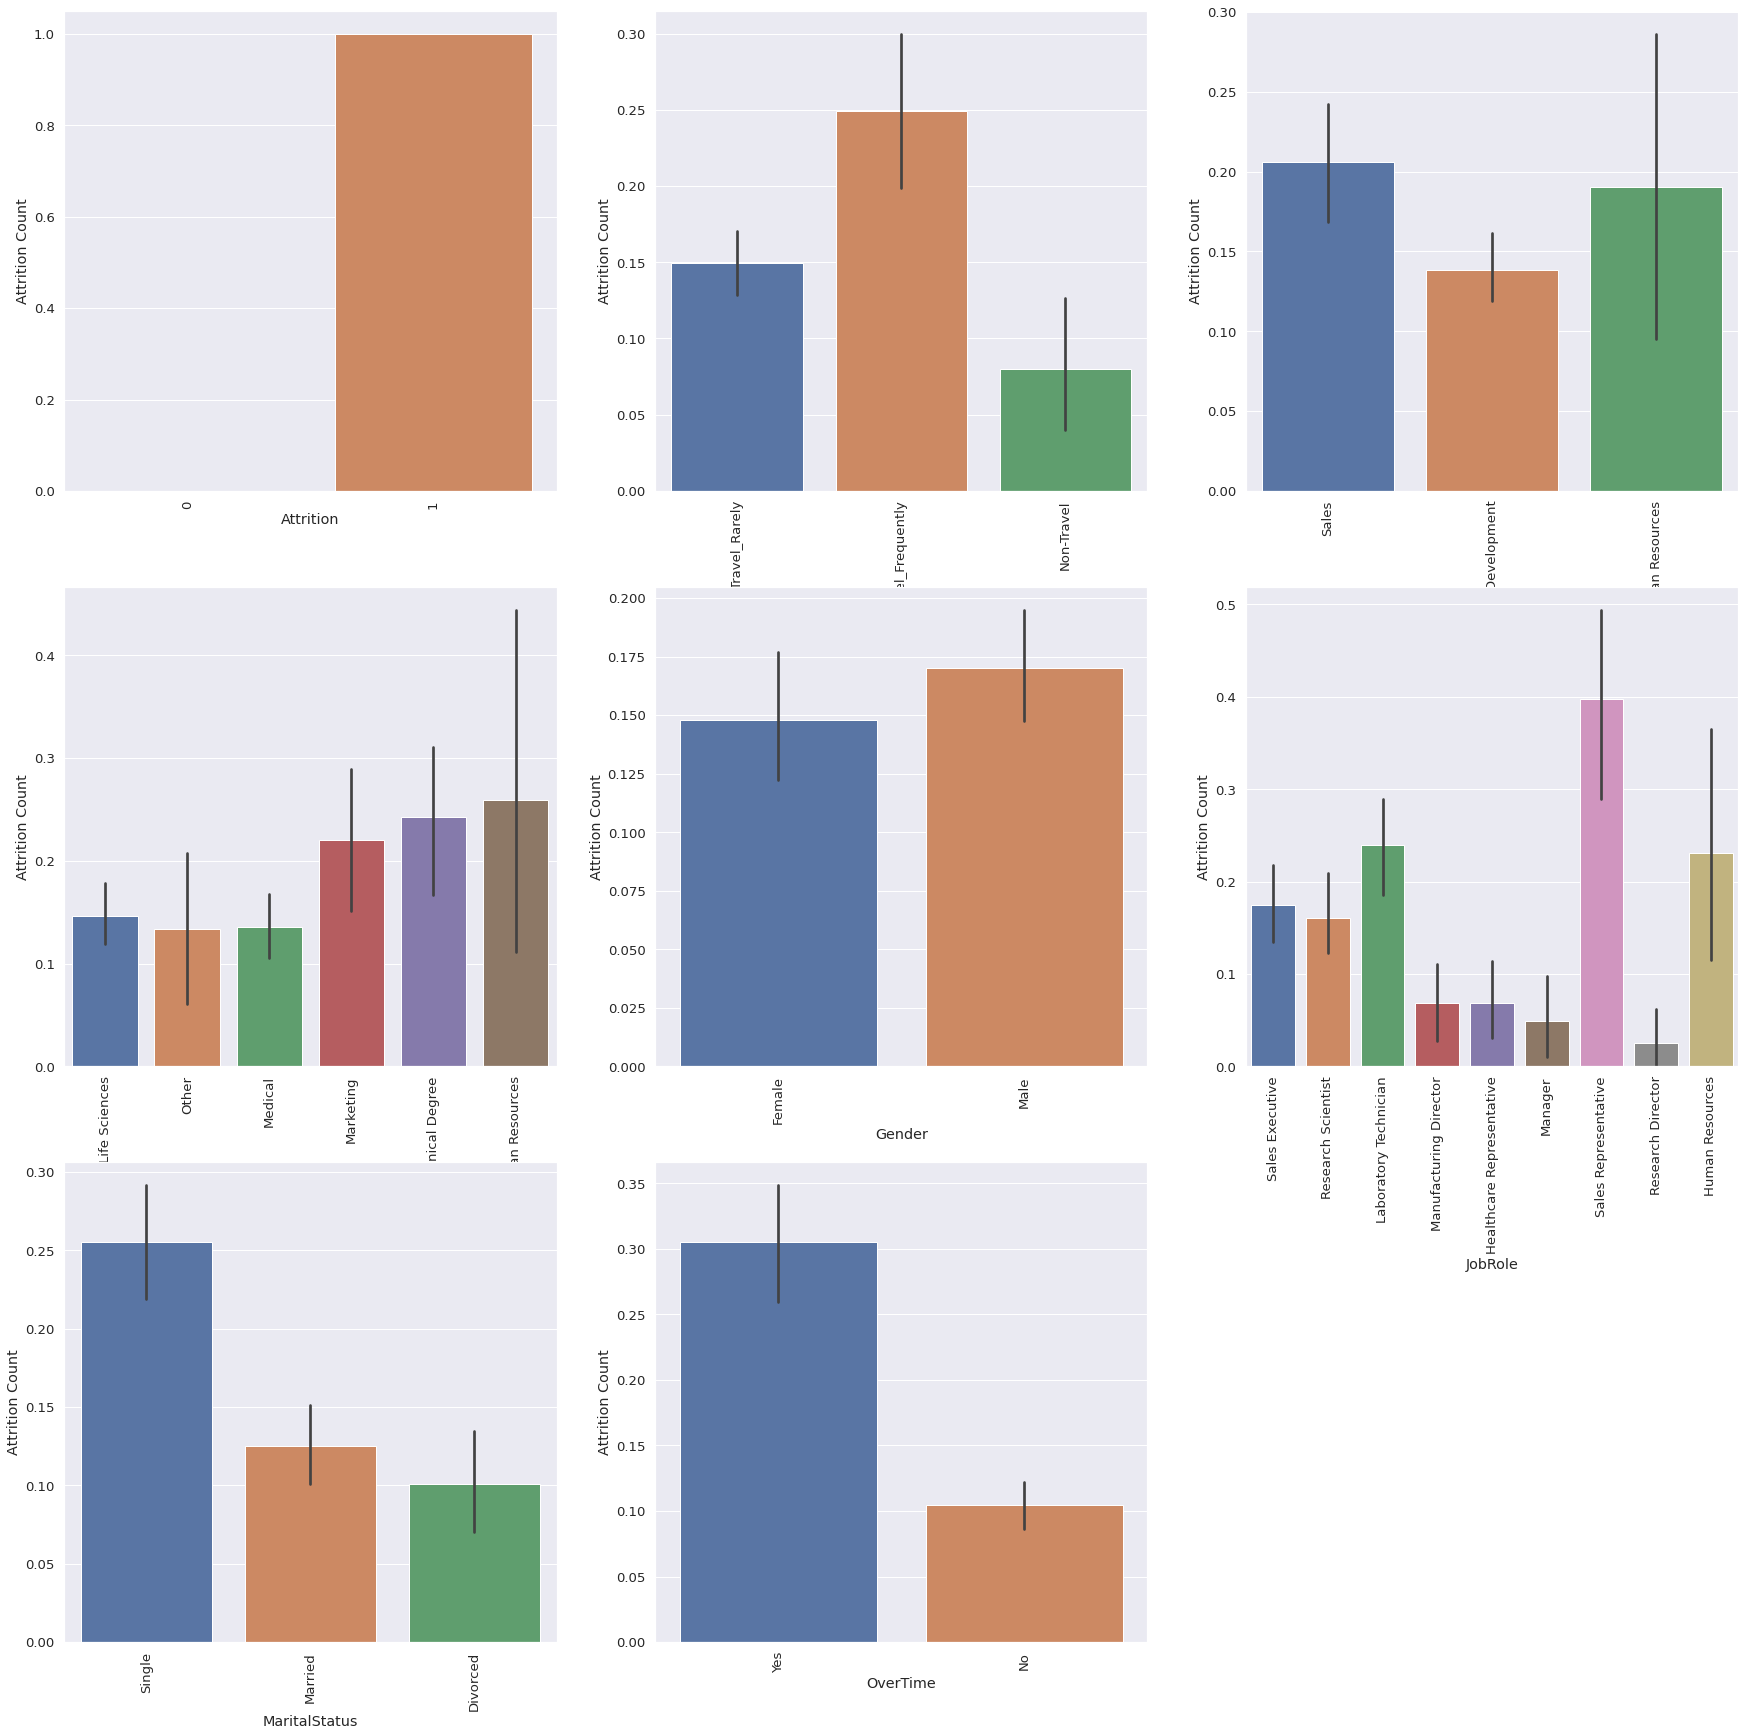

In [137]:
# Plotting how every feature correlate with the "target"
sns.set(font_scale=1.2)
plt.figure(figsize=(30, 30))

for i, column in enumerate(categorical_col, 1):
    plt.subplot(3, 3, i)
    g = sns.barplot(x=f"{column}", y='Attrition', data=df)
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    plt.ylabel('Attrition Count')
    plt.xlabel(f'{column}')

##Conclusions

**BusinessTravel** : The workers who travel alot are more likely to quit then other employees.

**Department** : The worker in Research & Development are more likely to stay then the workers on other departement.

**EducationField** : The workers with Human Resources and Technical Degree are more likely to quit then employees from other fields of educations.

**Gender** : The Male are more likely to quit.

**JobRole** : The workers in Laboratory Technician, Sales Representative, and Human Resources are more likely to quit the workers in other positions.

**MaritalStatus** : The workers who have Single marital status are more likely to quit the Married, and Divorced.

**OverTime** : The workers who work more hours are likely to quit then others.


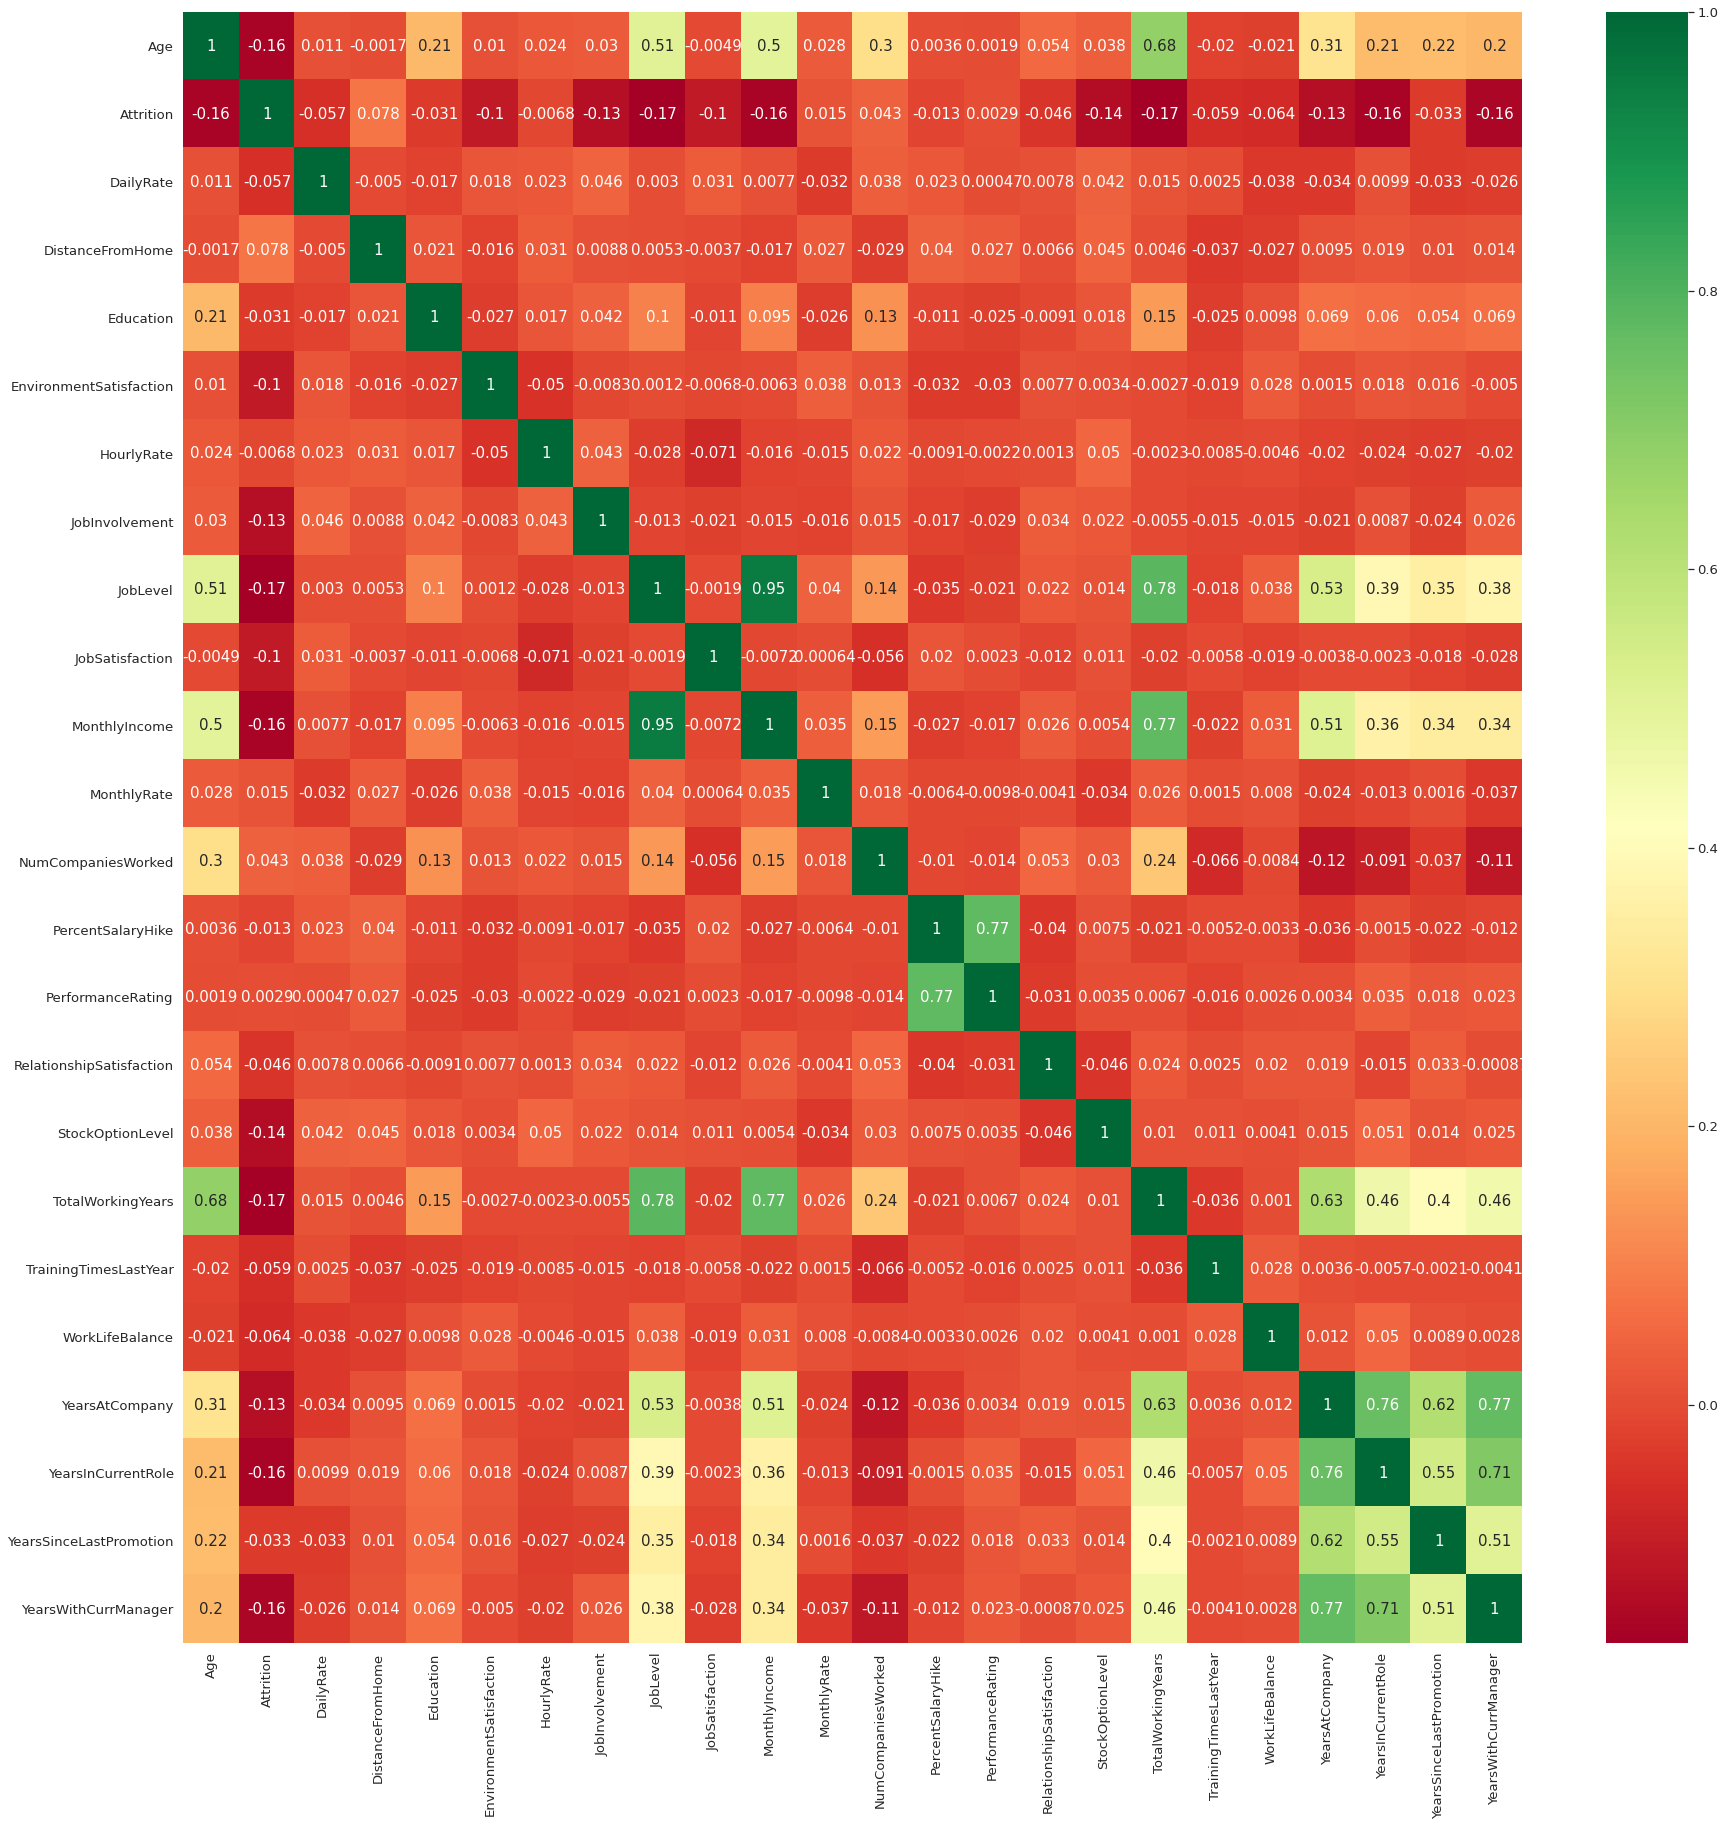

In [138]:
plt.figure(figsize=(30, 30))
sns.heatmap(df.corr(), annot=True, cmap="RdYlGn", annot_kws={"size":15})


In [0]:
categorical_col.remove('Attrition')

In [0]:
# Transform categorical data into dummies
# categorical_col.remove("Attrition")
# data = pd.get_dummies(df, columns=categorical_col)
# data.info()
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
for column in categorical_col:
    df[column] = label.fit_transform(df[column])

In [0]:
X = df.drop('Attrition', axis=1)
y = df.Attrition


In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

def print_score(clf, X, y, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        print("\nTrain Result:\n===========================================")
        print(f"accuracy score: {accuracy_score(y_train, pred):.4f}\n")
        train_accuracy.append(accuracy_score(y_train, pred))
        print(f"Classification Report: \n \tPrecision: {precision_score(y_train, pred)}\n\tRecall Score: {recall_score(y_train, pred)}\n\tF1 score: {f1_score(y_train, pred)}\n")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, clf.predict(X_train))}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        print("\nTest Result:\n===========================================")   
        test_accuracy.append(accuracy_score(y_test, pred))     
        print(f"accuracy score: {accuracy_score(y_test, pred)}\n")
        print(f"Classification Report: \n \tPrecision: {precision_score(y_test, pred)}\n\tRecall Score: {recall_score(y_test, pred)}\n\tF1 score: {f1_score(y_test, pred)}\n")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")
        scores = cross_val_score(clf, X, y, cv=10)
        cv_accuracy.append(scores.mean())
        cv_devia.append(scores.std()*2)
        print(f"10-fold Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [0]:
def plot_ROC(model, X_test, y_test):  
  probs = model.predict_proba(X_test)
  preds = probs[:,1]
  fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
  roc_auc = metrics.auc(fpr, tpr)
  roc_accuracy.append(roc_auc)
  # method I: plt
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [0]:
train_accuracy = []
test_accuracy = []
cv_accuracy = []
cv_devia = []
roc_accuracy = []

##Decision Tree

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

params = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 20))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 20)), 
}


model = DecisionTreeClassifier(random_state=42)
grid_search_cv = GridSearchCV(model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)

In [0]:
tree = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [148]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [149]:
print_score(tree, X, y, X_train, y_train, X_test, y_test, train=True)
print_score(tree, X, y, X_train, y_train, X_test, y_test, train=False)


Train Result:
accuracy score: 0.8882

Classification Report: 
 	Precision: 0.7520661157024794
	Recall Score: 0.5170454545454546
	F1 score: 0.6127946127946129

Confusion Matrix: 
 [[823  30]
 [ 85  91]]


Test Result:
accuracy score: 0.854875283446712

Classification Report: 
 	Precision: 0.46153846153846156
	Recall Score: 0.29508196721311475
	F1 score: 0.36000000000000004

Confusion Matrix: 
 [[359  21]
 [ 43  18]]

10-fold Cross Validation Accuracy: 0.84 (+/- 0.03)


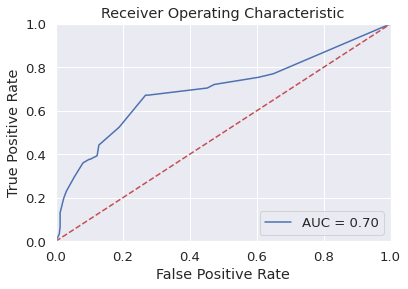

In [150]:
plot_ROC(tree,X_test,y_test)

##Random Forest

###GridSearchCV for random forest hyperparameter tuning

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


param_grid = {'max_depth':[50, 60, 75], 
              'n_estimators':[1400, 1425, 1450],
              'max_features':['sqrt'],
              'min_samples_split':[4, 5, 6], 
              'min_samples_leaf':[1], 
              'bootstrap':[ False], 
              'criterion':["gini"]}

rand_frst_clf = RandomForestClassifier(random_state=42, n_estimators=1000)

grid_rand_forest = GridSearchCV(rand_frst_clf, param_grid, scoring="accuracy", 
                                n_jobs=-1, verbose=1, cv=3)

In [152]:
rand_forest = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=1400,
                       n_jobs=None, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)
log_reg.fit(X_train,y_train)
rand_forest.fit(X_train, y_train)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    3.4s finished


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=1400,
                       n_jobs=None, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)

In [153]:
print_score(rand_forest, X, y, X_train, y_train, X_test, y_test, train=True)
print_score(rand_forest, X, y, X_train, y_train, X_test, y_test, train=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Train Result:
accuracy score: 1.0000

Classification Report: 
 	Precision: 1.0
	Recall Score: 1.0
	F1 score: 1.0



[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Confusion Matrix: 
 [[853   0]
 [  0 176]]



[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.2s finished



Test Result:
accuracy score: 0.8616780045351474

Classification Report: 
 	Precision: 0.5
	Recall Score: 0.09836065573770492
	F1 score: 0.1643835616438356

Confusion Matrix: 
 [[374   6]
 [ 55   6]]



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[

10-fold Cross Validation Accuracy: 0.86 (+/- 0.03)


[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.1s finished


###Importance of features in random forest

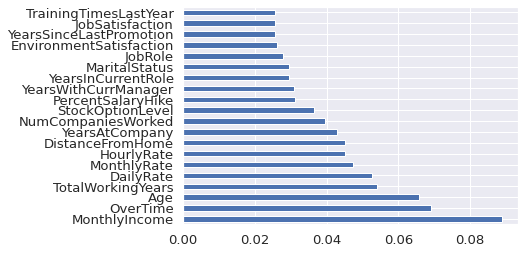

In [154]:
feat_importances = pd.Series(rand_forest.feature_importances_, index=X.columns)
feat_importances = feat_importances.nlargest(20)
feat_importances.plot(kind='barh')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:    0.2s finished


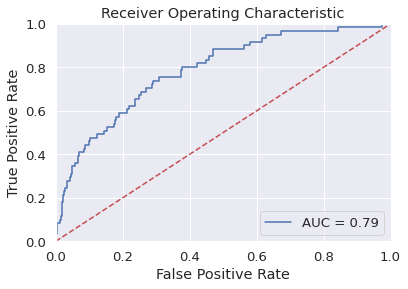

In [155]:
plot_ROC(rand_forest,X_test,y_test)

##Logistic Regression

In [156]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
clf = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
log_reg = GridSearchCV(clf, param_grid = grid_values, scoring="accuracy", refit=True, cv=3, verbose=1)
log_reg.fit(X_train, y_train)
print(log_reg.best_estimator_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    1.2s finished


In [157]:
log_reg = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

log_reg.fit(X_train,y_train)
print_score(log_reg, X, y, X_train, y_train, X_test, y_test, train=True)
print_score(log_reg, X, y, X_train, y_train, X_test, y_test, train=False)


Train Result:
accuracy score: 0.8338

Classification Report: 
 	Precision: 0.7272727272727273
	Recall Score: 0.045454545454545456
	F1 score: 0.08556149732620322

Confusion Matrix: 
 [[850   3]
 [168   8]]


Test Result:
accuracy score: 0.8639455782312925

Classification Report: 
 	Precision: 1.0
	Recall Score: 0.01639344262295082
	F1 score: 0.03225806451612903

Confusion Matrix: 
 [[380   0]
 [ 60   1]]

10-fold Cross Validation Accuracy: 0.84 (+/- 0.01)


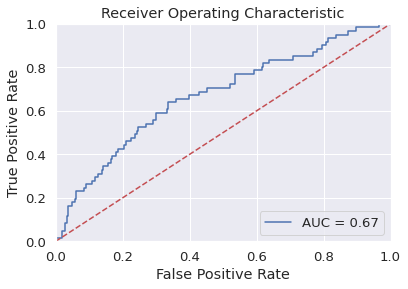

In [158]:
plot_ROC(log_reg,X_test,y_test)

##SVM

In [159]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV 

param_grid = {'C': [0.1, 1, 10, 100, 1000], 
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
			'kernel': ['rbf']} 

SVM = GridSearchCV(svm.SVC(), param_grid, scoring="accuracy", refit = True, cv=3, verbose = 1) 
SVM.fit(X_train,y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    3.7s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [160]:
print(SVM.best_estimator_)
best = SVM.best_estimator_

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [161]:
SVM=svm.SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
SVM.fit(X_train,y_train)
print_score(SVM, X, y, X_train, y_train, X_test, y_test, train=True)
print_score(SVM, X, y, X_train, y_train, X_test, y_test, train=False)


Train Result:
accuracy score: 1.0000

Classification Report: 
 	Precision: 1.0
	Recall Score: 1.0
	F1 score: 1.0

Confusion Matrix: 
 [[853   0]
 [  0 176]]


Test Result:
accuracy score: 0.8616780045351474

Classification Report: 
 	Precision: 0.0
	Recall Score: 0.0
	F1 score: 0.0

Confusion Matrix: 
 [[380   0]
 [ 61   0]]

10-fold Cross Validation Accuracy: 0.84 (+/- 0.01)


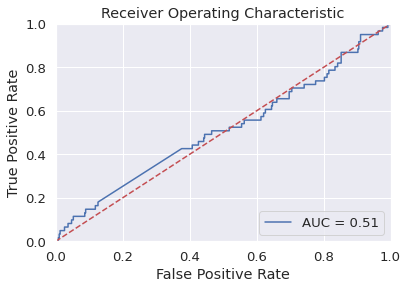

In [162]:
plot_ROC(SVM,X_test,y_test)

In [0]:
models = ['Decision Tree', 'Random Forest', 'Logistic Regression' , 'SVM' ]


In [165]:
results = pd.DataFrame({"10-fold Cross Validation":cv_accuracy[0:4], "Std Deviation(+/-)":cv_devia[0:4], "Roc score" : roc_accuracy[0:4], "Test Accuracy" : test_accuracy[0:4] , "Train Accuracy" : train_accuracy[0:4]} , index = models)
results

,10-fold Cross Validation,Std Deviation(+/-),Roc score,Test Accuracy,Train Accuracy
Decision Tree,0.838776,0.034446,0.695880,0.854875,0.888241
Random Forest,0.859864,0.027347,0.785807,0.861678,1.000000
Logistic Regression,0.839456,0.010884,0.669456,0.863946,0.833819
SVM,0.839456,0.006665,0.511972,0.861678,1.000000


Above we can compare all four models and by looking at Cross Validation scores along with standard deviation we can conclude that Random Forest is the best model.
Also the ROC Score of Random Forest is highest.